# 02 - Binary Classification with GeoLocation - Fitt Dataset

We will now the keras tokenizer to process just the country_name geolocation records.  Other characteristics of this notebook include:

  * Fitt dataset used as it has the most number of country matches by IP geolocation lookup
  * Geolocation uses CSV from ip2location.com imported into a sqlite database

## Restore previously saved df_sample DataFrame

In order to allow us to commence our training without having to repeat the previous data preparation steps, we will now load the df_sample dataframe using the pandas built-in from_json method.

In [86]:
from pathlib import Path
import pandas as pd
import os

cwd = Path.cwd()

file_path = os.path.join(cwd, 'saved_datasets', 'fitt_dataset_nodns.json' )
df_sample = pd.read_json(file_path)
print("[+] Loaded pandas dataframe from disk")

[+] Loaded pandas dataframe from disk


# the fun starts here...

We'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

In [87]:
from sklearn.model_selection import train_test_split
import numpy as np

df_sample['is_iot'] = np.where(df_sample['device_type'] == 'Other', 0, 1)
df_sample.drop('device_type', axis='columns', inplace=True)

In [69]:
features = df_sample.drop('is_iot', axis=1).values
labels = df_sample['is_iot'].values

In [70]:

df_sample.shape

(94668, 33)

In [71]:
features.shape[1]

32

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [73]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

94668::75734::18934


In [74]:
#  This is new
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, Y_train)
bm.score(X_test, Y_test)

0.6294496672652371

# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

class ModelFactory():

    def __init__(self, *args, **kwargs):
        self.params = args
        print(f'[+] Initialised with params: {self.params}')
        if 'model_name' in kwargs:
            self.model_name = kwargs['model_name']

    def get_model(self):

        model = Sequential()
        model.add(Dense(self.params[0], input_dim=features.shape[1], activation='relu'))
        if len(self.params) > 1:
            for it in self.params[1:]:
                eval(f"model.add(Dense({it}, activation='relu'))")
                eval(f"model.add(Dropout(0.2))")
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                                verbose=1, mode='auto', restore_best_weights=True)
        
        return model


In [76]:
from pathlib import Path
cwd = Path.cwd()
NEEDS_TRAINING = False

if NEEDS_TRAINING:

    model_a = ( ModelFactory(64,128,64).get_model(), 'ModelA' )
    model_b = ( ModelFactory(32,64,32).get_model(),  'ModelB' )

    histories = []

    for my_mod in [model_a, model_b]: 
        mod, mod_name = my_mod
        history = mod.fit(X_train, Y_train, epochs=67, batch_size=10, shuffle=True, verbose=2)
        # Serialise model to json
        model_json = mod.to_json()
        filepath = os.path.join(
                                cwd,
                                'saved_models',
                                f'{mod_name}_binary_nodns.json'
                                )
        with open(filepath, "w") as json_file:
            json_file.write(model_json)

        # Serialize weights to HDF5
        filepath = os.path.join(
                            cwd,
                            'saved_models',
                            f'{mod_name}_binary_nodns.h5'
                            )
        mod.save_weights(filepath)
        loss, accuracy = mod.evaluate(X_test, Y_test, verbose=2)
        print(f'{my_mod[1]}: Loss = {loss}, Accuracy={accuracy}')
        histories.append([history, loss, accuracy])
else:
    pass


[+] Initialised with params: (64, 128, 64)
[+] Initialised with params: (32, 64, 32)
Epoch 1/67
 - 14s - loss: 0.2155 - accuracy: 0.9057
Epoch 2/67
 - 15s - loss: 0.1783 - accuracy: 0.9214
Epoch 3/67
 - 16s - loss: 0.1651 - accuracy: 0.9258
Epoch 4/67
 - 17s - loss: 0.1633 - accuracy: 0.9264
Epoch 5/67
 - 20s - loss: 0.1571 - accuracy: 0.9286
Epoch 6/67
 - 14s - loss: 0.1548 - accuracy: 0.9293
Epoch 7/67
 - 14s - loss: 0.1525 - accuracy: 0.9307
Epoch 8/67
 - 16s - loss: 0.1507 - accuracy: 0.9325
Epoch 9/67
 - 13s - loss: 0.1476 - accuracy: 0.9337
Epoch 10/67
 - 13s - loss: 0.1473 - accuracy: 0.9342
Epoch 11/67
 - 16s - loss: 0.1454 - accuracy: 0.9351
Epoch 12/67
 - 16s - loss: 0.1441 - accuracy: 0.9357
Epoch 13/67
 - 15s - loss: 0.1422 - accuracy: 0.9360
Epoch 14/67
 - 18s - loss: 0.1408 - accuracy: 0.9361
Epoch 15/67
 - 14s - loss: 0.1400 - accuracy: 0.9369
Epoch 16/67
 - 14s - loss: 0.1376 - accuracy: 0.9380
Epoch 17/67
 - 14s - loss: 0.1372 - accuracy: 0.9384
Epoch 18/67
 - 15s - lo

# Cross-Entropy Loss (or Log Loss)


Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or 
“log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that 
penalizes the probability based on the distance from the expected value. The penalty is logarithmic, 
offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. 
A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average 
cross entropy across all examples.

The Python function below provides a pseudocode-like working implementation of a function for calculating 
the cross-entropy for a list of actual 0 and 1 values compared to predicted probabilities for the class 1.

<code>
from math import log

def binary_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		sum_score += actual[i] * log(1e-15 + predicted[i])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score
</code>

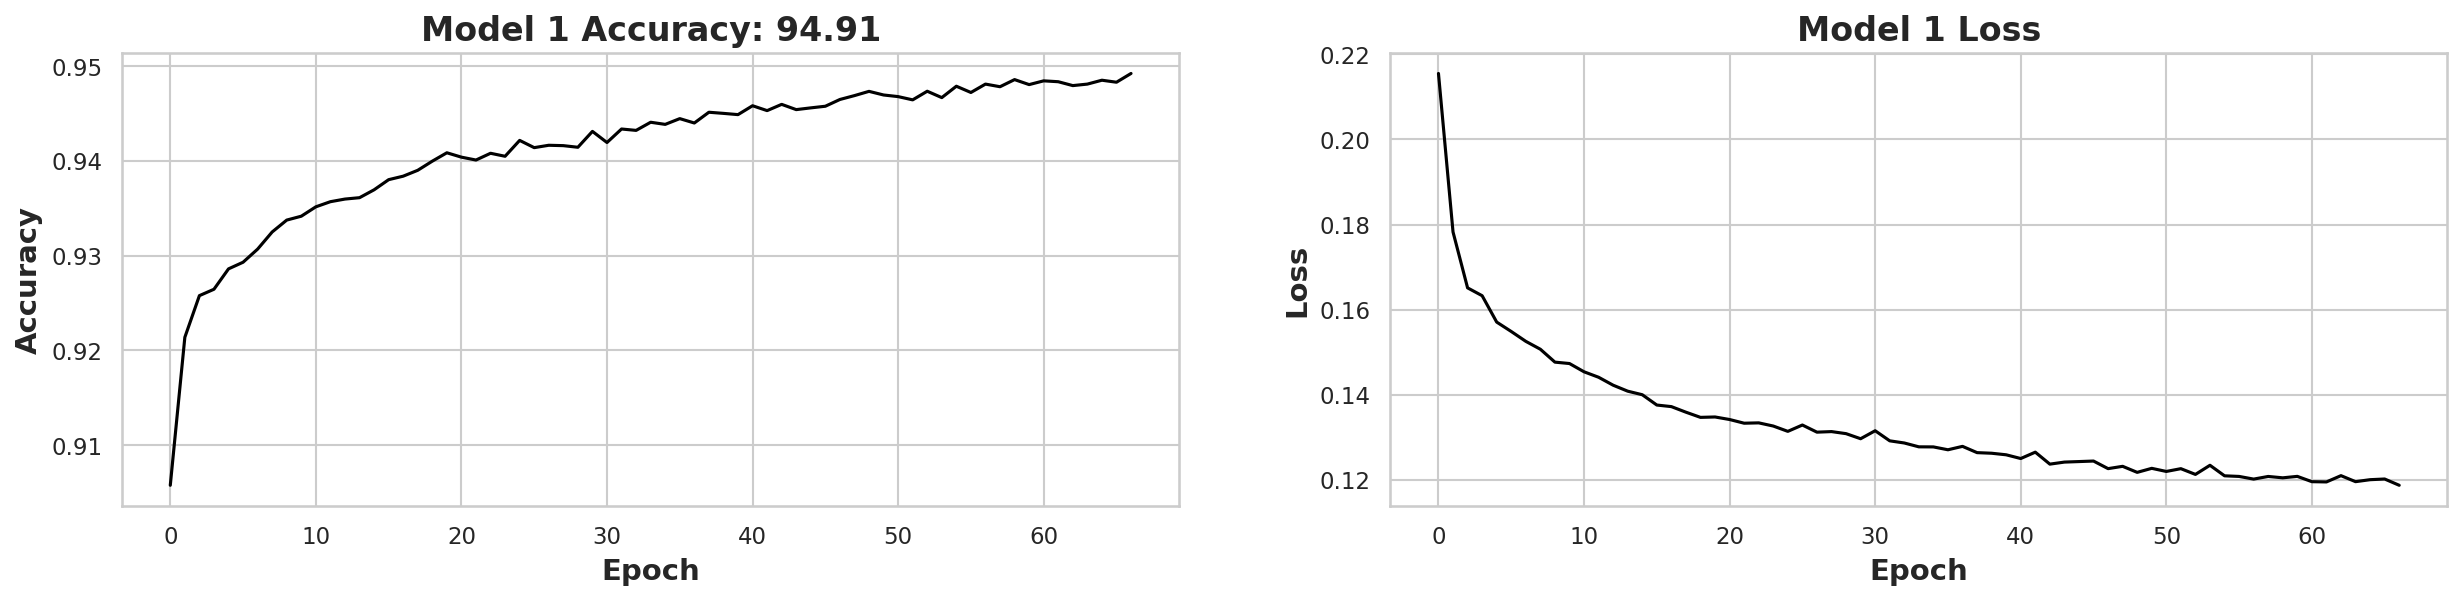

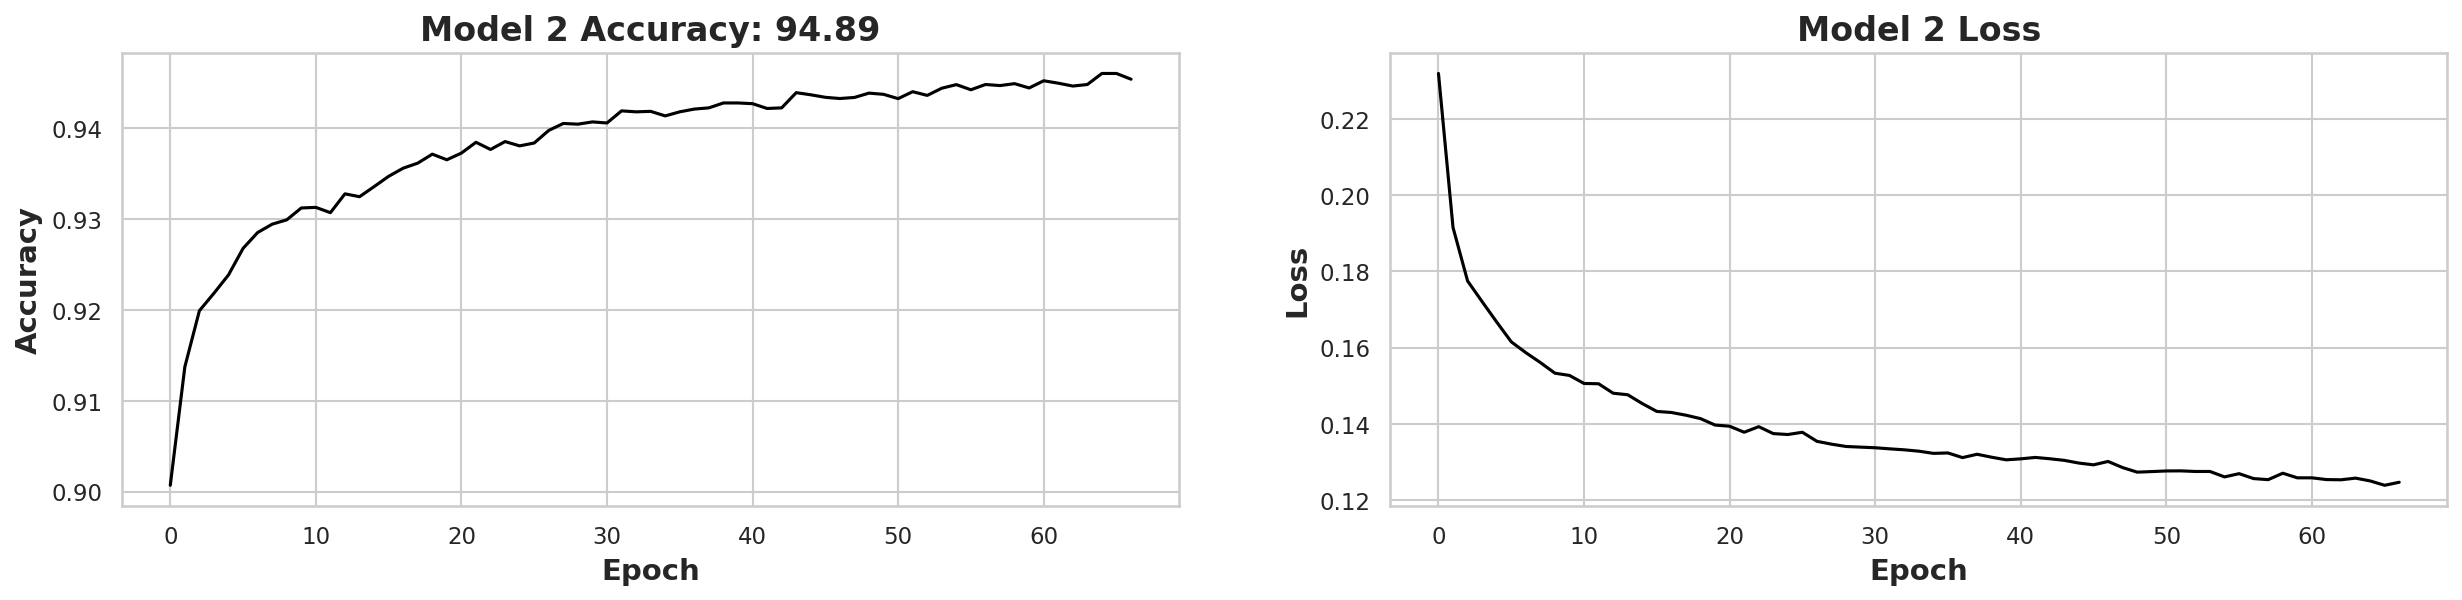

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20,4)
LEGEND = False

if NEEDS_TRAINING:

    for idx, hist_data in enumerate(histories, 1):
        history, loss, accuracy = hist_data
        # Plot training & validation accuracy values
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(history.history['accuracy'], color='black')
        plt.title(f'Model {idx} Accuracy: {(accuracy*100.0):.2f}', fontsize=16, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14, fontweight='bold')
        if LEGEND: ax1.legend('Train', loc='upper left')

        # # Plot training & validation loss values
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(history.history['loss'], color='black')
        plt.title(f'Model {idx} Loss', fontsize=16, fontweight='bold')
        plt.ylabel('Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14, fontweight='bold')
        if LEGEND: ax2.legend('Train', loc='upper left')
        plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/binary{idx}_nodns.png', dpi=150)
        plt.show()
else:
    pass


In [78]:
from keras.models import model_from_json
import os
import json

In [79]:
# load json and create model
import os
from pathlib import Path
cwd = Path.cwd()

json_file = open(
                os.path.join(
                    cwd,
                    'saved_models',
                    'ModelB_binary_nodns.json'
                ), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(cwd, 'saved_models', 'ModelB_binary_nodns.h5'))
print("[+] Loaded model from disk")

[+] Loaded model from disk


In [80]:
# These functions were adapted from:
#  Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred,y):
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams["figure.dpi"] = 150
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/roc_binary_nodns.png', dpi=150)
    plt.show()


/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


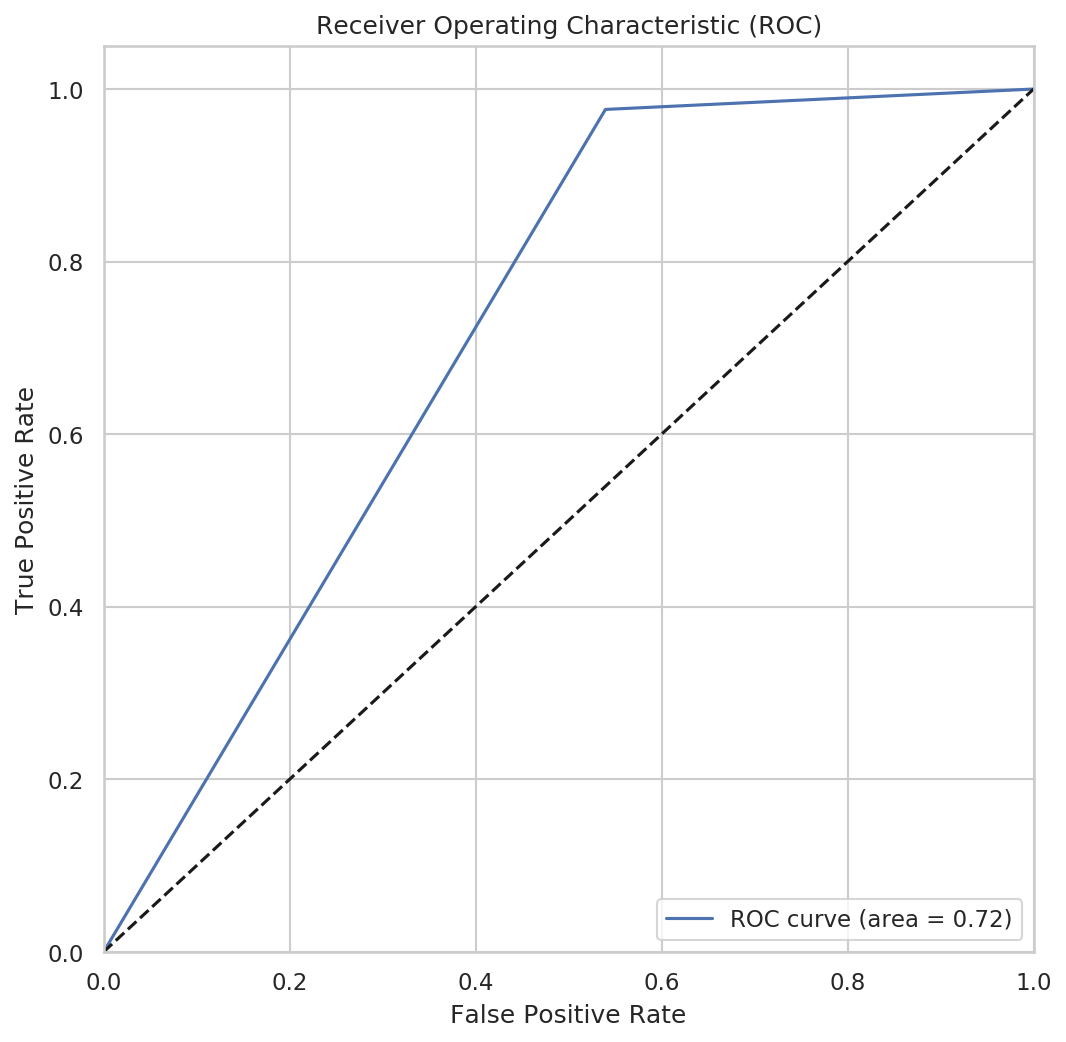

In [62]:
pred = loaded_model.predict(X_test)
pred = np.where(pred >= 0.5, 1, 0)
plot_roc(pred,Y_test)

## Calculation of Classification Accuracy

Accuracy refers to the number of rows in our dataset where the model predicted the target class.  Accuracy is only used for classification, not regression.

\begin{align}
accuracy = \frac{c}{N}
\end{align}

Where:
 * c is the number correct, and
 * N is the size of the evaluated set
 
Keras returns the probability percentage for each class.  We'll change these into actual model predictions with n.where.

In [81]:
pred = loaded_model.predict(X_test)
pred = np.where(pred >= 0.5, 1, 0)

/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


In [82]:
from sklearn import metrics
y_compare = np.where(Y_test >= 0.5, 1, 0)
score = metrics.accuracy_score(y_compare, pred)
print(f'[+] Accuracy score: {score}')

[+] Accuracy score: 0.9489278546530052


In [83]:
from sklearn.metrics import confusion_matrix
y_predict = loaded_model.predict(X_test)
y_predict = np.where(y_predict >= 0.5, 1, 0)
cm_df = pd.DataFrame(
    confusion_matrix(Y_test, y_predict),
        columns = [
            'Predict Non-IoT',
            'Predict IoT'
        ],
        index = [
            'True Non-IoT',
            'True IoT'
        ])

/home/ricdeez/.virtualenvs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


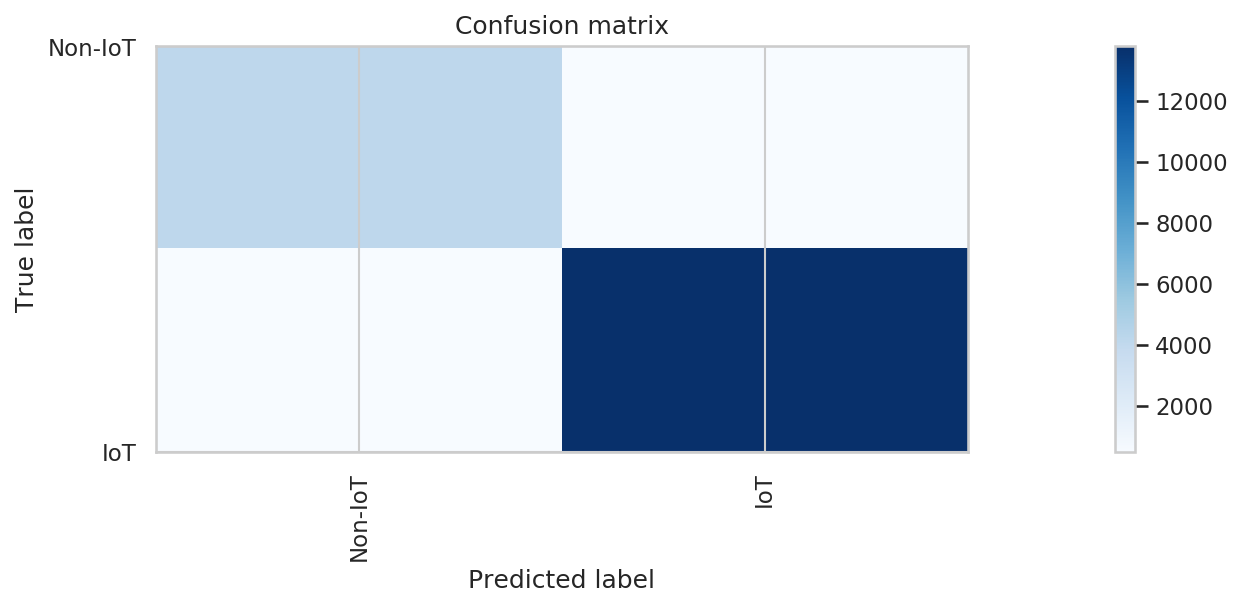

In [84]:
plt.figure()
plot_confusion_matrix(cm_df, ['Non-IoT', 'IoT'])
plt.savefig(f'/home/ricdeez/uni/projects/iotnetlearn/confusion_matrix_binary_nodns.png', dpi=150)


In [85]:
cm_df

,Predict Non-IoT,Predict IoT
True Non-IoT,4166,480
True IoT,487,13801
